In [13]:
import sys
import os
import io
import numpy as np
import matplotlib.pyplot as plt

# I use the numba package to try to accelerate some numerical calculations.
# If you don't have this package installed, then comment out the following line.
import numba 

# Testing ergodicity with the 1-d Ising model

## Single-flip proposal

So what are the necessary conditions such that a Markov chain with transition matrix $P$ produces the correct distribution $\pi$?

1. Irreducible (ergodic)
2. *Positive* recurrent, i.e. $\mathbb{E}(\tau_\mu)<\infty$
3. $P$ and $\pi$ are in detailed balance

Let us consider the 1-d Ising model again, but this time using the Metropolis-Hastings algorithm.  We will do this by sweeping over the sites on a ring (periodic boundary conditions), where at each site we propose a spin flip and apply the accept/reject test:

!["Figure showing 1 flip proposal"](1flip.png)


Recall that $S=-J\sum_x s_x s_{x+1}-h\sum_xs_x$, where $s_{n_x}=s_0$ (and $\beta J\to J$ and $\beta h\to h$).

If we flip the spin at site $x$, then $\Delta S=2Js_x(s_{x-1}+s_{x+1}+h)$

Here are some relevant function definitions

In [20]:
# this calculates the change in energy \Delta S when one flips the spin at position x
@numba.jit(nopython=True) # if you don't have numba, then comment this line
def calcDeltaS_1flip(s,J,h,x,nx): # the flipped spin is on site (x)
    return 2 * s[x]*(J*(s[(x+1)%nx] + s[(x-1)%nx]) + h)

# Given an array of values s (s needs to be a numpy array), this calculates the 
# bootstrap error using nBS bootstrap samples.
def bootstrap_error(s,nBS):  
    n=s.size
    bsmean = np.array([])
    for bs in range (nBS):
        index=np.random.randint(n,size=n) # random bootstrap indices
        bsmean = np.append(bsmean,np.array([s[index[i]] for i in range(n)]).mean())
    return bsmean.std()

And these are *exact* results that you derived for your homework assignment (right?)

In [3]:
def mExactN(J,h,N):
    s = np.sinh(h)
    c = np.cosh(h)
    expm4J = np.exp(-4*J)
    ratio = (c-np.sqrt(s**2+expm4J))/(c+np.sqrt(s**2+expm4J))
    answer = (1-ratio**N)/(1+ratio**N)
    answer *= s/np.sqrt(s**2+expm4J)
    return answer

# exact answer in thermodynamic limit
def mExact(J,h):
    s = np.sinh(h)
    c = np.cosh(h)
    expm4J = np.exp(-4*J)
    answer = s/np.sqrt(s**2+expm4J)
    return answer

In [21]:
nx=6
Lambda = nx # volume of lattice

J = 1

nTherm=500  # for every new value of J,h, I do this many sweeps for thermalization (i.e. no measurements)
nMeas = 1000  # number of measurements for each J,h

nBS = 100 # number of bootstrap samples to estimate error

# arrays that store the results for each value of J, h
magnetization = []
mag_error = []
probability = []

# here is a list of J,h parameters
# in this case J is fixed at 1, while h varies from -1 to 1 (with nSteps steps)
nSteps = 50
Jh_parameters = np.linspace((J,-1),(J,1), nSteps)  # = [[1,-1], [1,-.96], . . .,[1,.96],[1,1]]

nSweep=nx  # one sweep entails randomly sampling nx*ny spins (i.e. volume of lattice)

for J, h in Jh_parameters:
    # here I initialize local arrays
    m=np.array([])  # stores m
    prob=np.array([]) # stores accept/reject info
    
    # initialize a spin configuration with equal up and down spins 
    s = np.array([(-1)**i for i in range(nx)])  # [1, -1, 1, -1, . . .]
    
    # first thermalize for nTherm steps (I don't store anything here)
    for j in range(nTherm):  
        x = np.random.randint(nx) # picks a random spin site (nx)
        deltaS = calcDeltaS_1flip(s,J,h,x,nx)
        if np.random.uniform(0,1) <= np.exp(-deltaS): # also accept
            s[x] *= -1
        # otherwise reject
            
    # now go into production and make measurements
    for i in range(nMeas): 
        for j in range(nSweep):
            x = np.random.randint(nx) # randomly choose a site
            deltaS = calcDeltaS_1flip(s,J,h,x,nx)
            if np.random.uniform(0,1) <= np.exp(-deltaS): # accept
                s[x] *= -1
                prob=np.append(prob,1.)
            else:  # otherwise reject
                prob=np.append(prob,0.)
        # Now take measurements.  
        m=np.append(m,s.mean()

    # now tally the results for the specific value of J,h
    probability.append(prob.mean())
    magnetization.append(m.mean())
    mag_error.append(bootstrap_error(m,nBS))

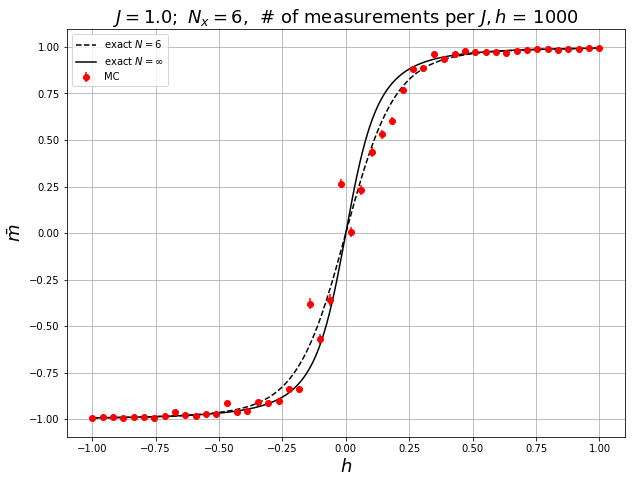

In [22]:
Jh_exact = np.linspace((J,-1),(J,1), 200)
MN_exact = [ mExactN(J, h, nx) for J, h in Jh_exact ]
M_exact = [ mExact(J, h) for J, h in Jh_exact ]

fig, ax = plt.subplots(1,1,figsize=(10,7.5))

ax.errorbar(Jh_parameters[:,1],magnetization,yerr=mag_error, fmt='ro',label='MC')
ax.plot(Jh_exact[:,1],MN_exact,'k--',label=r'exact $N={}$'.format(nx))
ax.plot(Jh_exact[:,1],M_exact,'k-',label=r'exact $N=\infty$')
ax.set_xlabel(r'$h$',fontsize=18)
ax.set_ylabel(r'$\bar{m}$', fontsize=18)
ax.set_title(r'$J={};\ N_x = {}$,  # of measurements per $J,h$ = {}'.format(J,nx,nMeas), fontsize=18)
ax.grid()
ax.legend(loc='upper left')


Recall how we showed detailed-balance.  First we have the transition probability for going from some spin configuration $s_i$ to a new spin configuration $s_j$.

\begin{equation}
P\left(s_{i} \rightarrow s_{j}\right)=g\left(s_{i} \rightarrow s_{j}\right) \times \min \underbrace{\left\{
\frac{\pi_{s_j}}{\pi_{s_i}}, 1
\right\}}_{\text {accept/reject}}
\end{equation}

where 

\begin{equation}
\frac{\pi_{s_{j}}}{\pi_{s_{i}}}=\exp \left(-\left(S\left(s_{j}\right)-S\left(s_{i}\right)\right)=\exp (-\Delta S)\right.
\end{equation}

The following establishes *detailed balance*:

\begin{align}
\pi_{s_{i}} P\left(s_{i} \rightarrow s_{j}\right) &=\pi_{s_{i}} g\left(s_{i} \rightarrow s_{j}\right) \times \min \left\{\frac{\pi_{s_{j}}}{\pi_{s_{i}}}, 1\right\} \\
&=\pi_{s_{j}} g\left(s_{j} \rightarrow s_{i}\right) \times \min \left\{1, \frac{\pi_{s_{i}}}{\pi_{s_{j}}}\right\}=\pi_{s_{j}} P\left(s_{j} \rightarrow s_{i}\right)
\end{align}

Here we used the fact that $g(s_i\to s_j)$ is _reversible_, i.e. $g(s_j\to s_i)=g(s_i\to s_j)$.

## 2-flip proposals

Let us always two spin flips by choosing a spin site at $x$, flipping it, and ***also*** flipping the spin at $x+1$.  Then we apply the accept/reject test:

!["Figure showing 2 adjacent flips as proposal"](2flip.png)

To implement this, we'll need a new function to calculate $\Delta S$ when we flip two adjacent spins.  A little bit of math shows that if we flip the spins at site $x$ and $x+1$ then 

\begin{align}
\Delta S&=2\left[J\left(s_{x-1}s_x+s_{x+1}s_{x+2}\right)+h\left(s_x+s_{x+1}\right)\right]\\
&=2\left[s_x\left(Js_{x-1}+h\right)+s_{x+1}\left(Js_{x+2}+h\right)\right]
\end{align}

Here's the code for this:

In [7]:
@numba.jit(nopython=True) # if you don't have numba, then comment this line
def calcDeltaS_2flips(s,J,h,x,nx): # the flipped spins are at sites x and x+1
    return 2 * (s[x]*(J*s[(x-1)%nx] + h) + s[(x+1)%nx]*(J*s[(x+2)%nx] + h))

Now let's repeat the calculation, but always do two adjacent flips before accept/reject.

In [16]:
nx=6
Lambda = nx # volume of lattice

J = 1

nTherm=500  # for every new value of J,h, I do this many sweeps for thermalization (i.e. no measurements)
nMeas = 1000  # number of measurements for each J,h

nBS = 100 # number of bootstrap samples to estimate error

# arrays that store the results for each value of J, h
magnetization = []
mag_error = []
probability = []

# here is a list of J,h parameters
# in this case J is fixed at 1, while h varies from -1 to 1 (with nSteps steps)
nSteps = 50
Jh_parameters = np.linspace((J,-1),(J,1), nSteps)

nSweep=nx  # one sweep entails randomly sampling nx*ny spins (i.e. volume of lattice)

# initialize a spin configuration with random up/down spins (i.e. "hot start")
# note that np.random.randint(N) samples a random integer uniformly in [0,N-1] ! 
#s=np.array([2*np.random.randint(2)-1 for i in range(nx)] )

for J, h in Jh_parameters:
    # here I initialize local arrays
    m=np.array([])  # stores m
    prob=np.array([]) # stores accept/reject info
    
    # initialize a spin configuration with equal up and down spins 
    s = np.array([(-1)**i for i in range(nx)]) 
    
    # first thermalize for nTherm steps (I don't store anything here)
    for j in range(nTherm):  
        x = np.random.randint(nx) # picks a random spin site (nx)
        deltaS = calcDeltaS_2flips(s,J,h,x,nx)
        if np.random.uniform(0,1) <= np.exp(-deltaS): # also accept
            s[x] *= -1
            s[(x+1)%nx] *= -1
        # otherwise reject
            
    # now go into production and make measurements
    for i in range(nMeas): 
        for j in range(0,nSweep,2):
            x = np.random.randint(nx) # randomly choose a site
            deltaS = calcDeltaS_2flips(s,J,h,x,nx)
            if np.random.uniform(0,1) <= np.exp(-deltaS): # accept
                s[x] *= -1
                s[(x+1)%nx] *= -1
                prob=np.append(prob,1.)
            else:  # otherwise reject
                prob=np.append(prob,0.)
        # Now take measurements.  
        m=np.append(m,s.mean())
        
    # now tally the results for the specific value of J,h
    probability.append(prob.mean())
    magnetization.append(m.mean())
    mag_error.append(bootstrap_error(m,nBS))

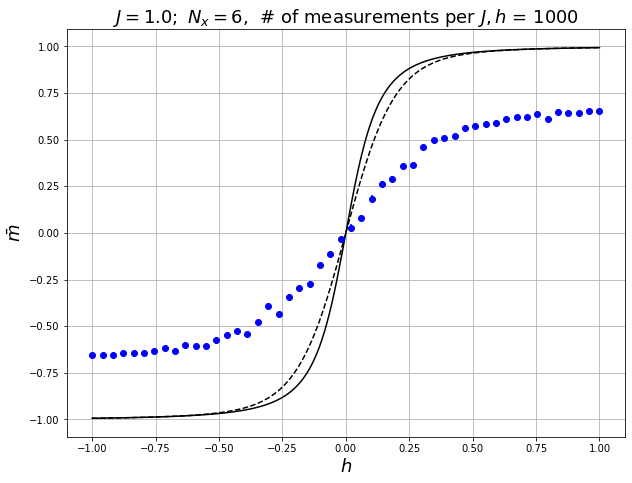

In [17]:
Jh_exact = np.linspace((J,-1),(J,1), 200)
MN_exact = [ mExactN(J, h, nx) for J, h in Jh_exact ]
M_exact = [ mExact(J, h) for J, h in Jh_exact ]

fig, ax = plt.subplots(1,1,figsize=(10,7.5))

ax.errorbar(Jh_parameters[:,1],magnetization,yerr=mag_error, fmt='bo')
ax.plot(Jh_exact[:,1],MN_exact,'k--',label='exact')
ax.plot(Jh_exact[:,1],M_exact,'k-',label=r'$N=\infty$')
ax.set_xlabel(r'$h$',fontsize=18)
ax.set_ylabel(r'$\bar{m}$', fontsize=18)
ax.set_title(r'$J={};\ N_x = {}$,  # of measurements per $J,h$ = {}'.format(J,nx,nMeas), fontsize=18)
ax.grid()

Here's a figure that shows results for different values of $n_x$, calculated using $N_{meas}=10000$.  Note that the result for the *2-flips* proposals changes for different values of $n_x$.  This is a clear sign of violation of ergodicity.

!["Figure numerous runs"](1d_nonErgodic_Ising.pdf)

Note that every calculation had the same initial spin configuration:

    s = np.array([(-1)**i for i in range(nx)]) # disordered state
    
What happens if one chooses a different initial spin configuration, e.g. 

    s = np.array([1 for i in range(nx)])  # all spins up
    
??